In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import numpy as np

def load_and_label_data(base_path, label, max_files=None):
    combined_100KHzdata = []
    combined_2000KHzdata = []

    file_counter = 0

    for timestamp_folder in os.listdir(base_path):
        if max_files and file_counter >= max_files:
            break

        timestamp_folder_path = os.path.join(base_path, timestamp_folder, "raw")
        timestamp = timestamp_folder.split('_')[0] + '_' + timestamp_folder.split('_')[1]
        timestamp = pd.to_datetime(timestamp, format='%Y.%m.%d_%H.%M.%S')

        # Process 2000KHz data
        df_2000KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling2000KHz_AEKi-0.parquet"))
        df_2000KHz_grouped = df_2000KHz.groupby(df_2000KHz.index // 10000).mean().reset_index(drop=True)
        df_2000KHz_grouped['timestamp'] = timestamp + pd.to_timedelta(df_2000KHz_grouped.index, unit='ms')
        df_2000KHz_grouped['label'] = label

        # Process 100KHz data
        df_100KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling100KHz_Irms_Grinding-Grinding spindle current L1-Grinding spindle current L2-Grinding spindle current L3-0.parquet"))
        df_100KHz_grouped = df_100KHz.groupby(df_100KHz.index // 10000).mean().reset_index(drop=True)
        df_100KHz_grouped['timestamp'] = timestamp + pd.to_timedelta(df_100KHz_grouped.index, unit='ms')
        df_100KHz_grouped['label'] = label

        combined_100KHzdata.append(df_100KHz_grouped)
        combined_2000KHzdata.append(df_2000KHz_grouped)

        file_counter += 1

    final_combined_100KHzdata = pd.concat(combined_100KHzdata, ignore_index=True)
    final_combined_2000KHzdata = pd.concat(combined_2000KHzdata, ignore_index=True)

    return final_combined_100KHzdata, final_combined_2000KHzdata

def preprocess_data(ok_data_path, nok_data_path):
    ok_100KHzdata, ok_2000KHzdata = load_and_label_data(ok_data_path, label=0)
    nok_100KHzdata, nok_2000KHzdata = load_and_label_data(nok_data_path, label=1)

    all_100KHzdata = pd.concat([ok_100KHzdata, nok_100KHzdata], ignore_index=True)
    all_2000KHzdata = pd.concat([ok_2000KHzdata, nok_2000KHzdata], ignore_index=True)

    return all_100KHzdata, all_2000KHzdata

def combine_and_interpolate_data(data_100KHz, data_2000KHz):
    combined_data = pd.merge_asof(data_100KHz.sort_values('timestamp'),
                                  data_2000KHz.sort_values('timestamp'),
                                  on='timestamp',
                                  by='label',
                                  direction='nearest')

    combined_data = combined_data.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

    return combined_data

def normalize_data(combined_data):
    features = combined_data.drop(columns=['timestamp', 'label'])
    timestamps = combined_data['timestamp']
    labels = combined_data['label']

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    normalized_data = pd.DataFrame(normalized_features, columns=features.columns)
    normalized_data.insert(0, 'timestamp', timestamps)
    normalized_data['label'] = labels.values

    return normalized_data

import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    accuracy = accuracy_score(y, y_pred_classes)
    precision = precision_score(y, y_pred_classes)
    recall = recall_score(y, y_pred_classes)
    f1 = f1_score(y, y_pred_classes)

    print(classification_report(y, y_pred_classes))

    cm = confusion_matrix(y, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return accuracy, precision, recall, f1

ok_data_path = '/content/gdrive/MyDrive/Data/OK_Measurements'
nok_data_path = '/content/gdrive/MyDrive/Data/NOK_Measurements'

all_100KHzdata, all_2000KHzdata = preprocess_data(ok_data_path, nok_data_path)
combined_data = combine_and_interpolate_data(all_100KHzdata, all_2000KHzdata)
normalized_data = normalize_data(combined_data)
normalized_data = shuffle(normalized_data, random_state=42)


Mounted at /content/gdrive


KNN Model Accuracy: 0.9994526546250684
Confusion Matrix:
 [[1992    0]
 [   2 1660]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1992
           1       1.00      1.00      1.00      1662

    accuracy                           1.00      3654
   macro avg       1.00      1.00      1.00      3654
weighted avg       1.00      1.00      1.00      3654

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4615
           1       1.00      1.00      1.00      3908

    accuracy                           1.00      8523
   macro avg       1.00      1.00      1.00      8523
weighted avg       1.00      1.00      1.00      8523



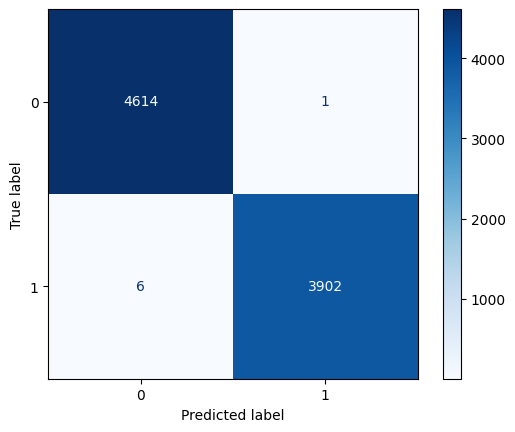

Training Accuracy: 99.92%, Training Precision: 1.00, Training Recall: 1.00, Training F1 Score: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1992
           1       1.00      1.00      1.00      1662

    accuracy                           1.00      3654
   macro avg       1.00      1.00      1.00      3654
weighted avg       1.00      1.00      1.00      3654



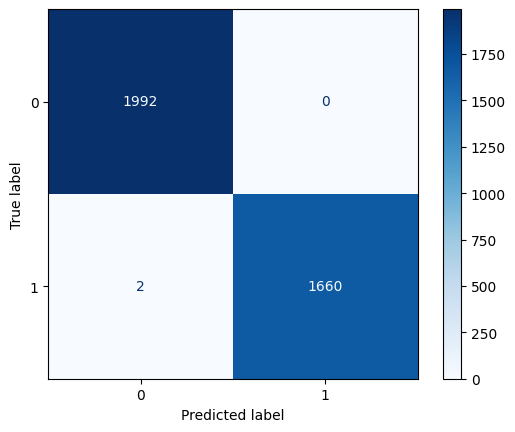

Test Accuracy: 99.95%, Test Precision: 1.00, Test Recall: 1.00, Test F1 Score: 1.00

Results Summary:
    Dataset  Accuracy  Precision    Recall  F1 Score
0  Training  0.999179   0.999744  0.998465  0.999104
1      Test  0.999453   1.000000  0.998797  0.999398


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

features = normalized_data.drop(columns=['label'])
labels = normalized_data['label']

features = features.apply(pd.to_numeric, errors='coerce')
labels = pd.to_numeric(labels, errors='coerce')

features = features.dropna()
labels = labels[features.index]

# Normalize data separately for training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("KNN Model Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Evaluate model on training and test data
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(knn, X_train_scaled, y_train)
print(f"Training Accuracy: {train_accuracy*100:.2f}%, Training Precision: {train_precision:.2f}, Training Recall: {train_recall:.2f}, Training F1 Score: {train_f1:.2f}")

test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(knn, X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%, Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1 Score: {test_f1:.2f}")

results = {
    "Dataset": ["Training", "Test"],
    "Accuracy": [train_accuracy, test_accuracy],
    "Precision": [train_precision, test_precision],
    "Recall": [train_recall, test_recall],
    "F1 Score": [train_f1, test_f1]
}

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)
